In [ ]:
from pathlib import Path
import pandas as pd
import pyreadstat

STU_PATH = Path("../data/raw/Student Data.sav") #path to the student data file
SCH_PATH = Path("../data/raw/School Data.sav") #path to the school data file

PREDICTORS = [
    #Individual-level Predictors
    "ST004D01T", #Gender
    "AGE", #Age
    "GRADE", #Grade
    "BSMJ", #Expected Occupational Status
    "JOYREAD", #Joy of Reading
    "SCREADCOMP", #Reading Self-Concept: Competence
    "SCREADDIFF", #Reading Self-Concept: Difficulty
    "COMPETE", #Competitiveness
    "WORKMAST", #Work Mastery Orientation
    "GFOFAIL", # General Fear of Failure
    "EUDMO", #Sense of Meaning in Life (Eudaimonia)  
    "RESILIENCE", #Resilience
    "MASTGOAL", #Mastery Goal Orientation

    #Proximal-level Predictors
    "REPEAT", #Grade Repetition History
    "UNDREM", #Meta-cognition: Understanding & Remembering 
    "METASUM", #Meta-cognition: Summarizing
    "METASPAM", #Meta-cognition: Assessing Credibility

    #Microsystem-Level Factors (Family, Peers, & School CLimate)
    "EMOSUPS", #Parental Emotional Support
    "DURECEC", #Duration in Early Childhood Education and Care
    "BELONG", #School Belonging
    "PERCOMP", #Perceived School Competitiveness 
    "PERCOOP", #Perceived School Cooperation
    "ATTLNACT", #Attitudes Towards Learning Activities
    "DISCLIMA", #Disciplinary Climate (Language Lessons)
    "TEACHSUP", #Teacher Support (Language Lessons)
    "DIRINS", #Teacher-Directed Instruction 
    "PERFEED", #Perceived Feedback from Teachers
    "STIMREAD", #Teacher's Stimulation of Reading Engagement
    "ADAPTIVITY", #Adapation of Instruction
    "TEACHINT", #Perceived Teacher Interest 

    #Macrosystem/Exosystem-level Predictors
    "ESCS", #Family Socioeconomic Status(Index)
    "EDUSHORT", #Shortage of Educational Resources
    "RATCMP1", #Number of Computers per Student
    "RATCMP2", #Percentage of Computers Connected to the Internet
]

print("Loading student data...")

stu_df, _ = pyreadstat.read_sav(STU_PATH, apply_value_formats=False) #loads student data
stu_df = stu_df[stu_df["CNT"] == "JPN"] #filters for Japan data onlhy

print("Loading school data...")

sch_df, _ = pyreadstat.read_sav(SCH_PATH, apply_value_formats=False) #loads school data
sch_jpn = sch_df[sch_df["CNT"] == "JPN"][["CNTSCHID","RATCMP1","RATCMP2","EDUSHORT"]] #filters for Japan data only 

print("Merging student + school data...")

df = stu_df.merge(sch_jpn, on = "CNTSCHID", how = "left") #merges student and school data

DV = "BEINGBULLIED" #dependent variable of BeingBullied
df = df[PREDICTORS + [DV, "CNTSCHID"]] #selects predictors and dependent variable

missing = (df.isna().mean() * 100).sort_values(ascending=False) #calculates percentage of missing values for each variable
print("\nTop 20 variables by % missing (Japan):") 
print(missing.head(20).round(1)) 

out_path = Path("../data/processed/japan_clean.pkl") #path to save the cleaned data
df.to_pickle(out_path)
print(f"\nSaved cleaned Japan data → {out_path} (rows: {len(df)})")

Loading student data...
Loading school data...
Merging student + school data...

Top 20 variables by % missing (Japan):
REPEAT          100.0
BSMJ             22.2
DURECEC          20.6
PERCOOP           4.2
BEINGBULLIED      3.2
PERCOMP           3.1
METASUM           3.0
METASPAM          3.0
UNDREM            2.8
EMOSUPS           2.4
BELONG            1.9
EUDMO             1.9
MASTGOAL          1.8
WORKMAST          1.8
SCREADCOMP        1.7
GFOFAIL           1.7
RESILIENCE        1.6
ADAPTIVITY        1.5
PERFEED           1.5
SCREADDIFF        1.5
dtype: float64

Saved cleaned Japan data → ..\data\processed\japan_clean.pkl (rows: 6109)


In [ ]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

df = pd.read_pickle("../data/processed/japan_clean.pkl") #loads the processed Japan data 

df = df.drop(columns = ["REPEAT"]) #drops the REPEAT column

DV = "BEINGBULLIED" 
X = df.drop(columns = [DV, "CNTSCHID"]) #drop DV + School ID and has only features
y = df[DV].copy() #copy the dependent variable

X["ST004D01T"] = X["ST004D01T"].map({1:0, 2:1}) #maps male variable to 0 and female variable to 1

num_cols = X.columns.tolist() #stores the names of all features 

imputer = SimpleImputer(strategy = "median")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns = num_cols, index = X.index) #fills in missing values using the median of each column 

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns = num_cols, index = X.index) #standardize the data so that mean = 0 and STD = 1

jpn_final = X_scaled.copy() 
jpn_final[DV] = y.values #combines the scaled features with the dependent variable back into single dataframe

out_final = Path("../data/processed/japan_clean_final.pkl") #saves data to a new file 
jpn_final.to_pickle(out_final)
print(f"Saved final cleaned Japan data → {out_final} (shape: {jpn_final.shape})")

Saved final cleaned Japan data → ..\data\processed\japan_clean_final.pkl (shape: (6109, 34))


In [2]:
# Load and inspect

from pathlib import Path
import pandas as pd

final_df = pd.read_pickle(Path("../data/processed/japan_clean_final.pkl"))
print(final_df.shape)
print(final_df.head())
print(final_df.isna().sum().sum())  # Should be 0 missing


(6109, 34)
   ST004D01T       AGE  GRADE      BSMJ   JOYREAD  SCREADCOMP  SCREADDIFF  \
0   1.021679 -1.561235    0.0  0.981977 -0.263534   -0.099010    0.374871   
1   1.021679  0.171347    0.0  0.220660  1.205566    0.728455   -1.121728   
2  -0.978781  1.037637    0.0  0.220660  2.143527   -0.099010   -0.494527   
3  -0.978781  0.171347    0.0  1.299334  1.345802   -0.500685    0.487861   
4  -0.978781  0.483211    0.0  1.220420  0.366557    0.218219   -0.011598   

    COMPETE  WORKMAST   GFOFAIL  ...    DIRINS   PERFEED  STIMREAD  \
0  0.390101  0.222888  0.086421  ... -0.232583  0.838040 -0.229062   
1 -0.067651 -0.964994 -0.347561  ...  0.930705  2.390467  1.938651   
2 -0.067651  0.011500 -0.539411  ...  1.638575 -0.857618  1.938651   
3  1.037913 -0.883683  0.751257  ...  0.206409 -0.527402 -0.006641   
4  1.449662  0.655456  0.751257  ... -1.250101 -0.527402 -0.257112   

   ADAPTIVITY  TEACHINT      ESCS  EDUSHORT   RATCMP1   RATCMP2  BEINGBULLIED  
0   -0.078844  0.418802  

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import pandas as pd 
import numpy as np


final_df = pd.read_pickle("../data/processed/japan_clean_final.pkl") #load the final cleaned Japan data
final_df = final_df.dropna(subset=["BEINGBULLIED"]) #drop rows with missing values in the dependent variable 

#seperate features/predictors (X) and dependent variable (y)
X = final_df.drop(columns = ["BEINGBULLIED"])
y = final_df["BEINGBULLIED"]

rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

scores = cross_val_score(rf, X, y, cv=5, scoring="r2", n_jobs=-1) #performs 5-fold cross-validation 
print(f"RF 5-fold R² scores:", np.round(scores, 3))
print(f"Mean R²:", np.round(scores.mean(), 3))  


RF 5-fold R² scores: [0.111 0.113 0.108 0.142 0.075]
Mean R²: 0.11


In [10]:
rf.fit(X,y) 

importances = rf.feature_importances_ #get feature importances
feature_names = X.columns.tolist() #get feature names
feature_importances = sorted(zip(feature_names, importances), key = lambda x: x[1], reverse = True) #sort features by importance 

print("\nTop 10 predictors of BEINGBULLIED (Japan):")

for feat, imp in feature_importances[:10]:
    print(f"{feat:.12s} : {imp:.4f}")



Top 10 predictors of BEINGBULLIED (Japan):
BELONG : 0.1306
ESCS : 0.0678
DISCLIMA : 0.0533
JOYREAD : 0.0443
RATCMP1 : 0.0430
RESILIENCE : 0.0358
BSMJ : 0.0336
GFOFAIL : 0.0324
DIRINS : 0.0306
TEACHINT : 0.0292


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.metrics import make_scorer, mean_absolute_error
import numpy as np 

#defines base random forest regressor with default parameters
rf_base = RandomForestRegressor(
    n_estimators = 100, 
    max_depth = None, 
    min_samples_leaf = 1, 
    random_state = 42
)

rkf = RepeatedKFold(n_splits = 5, n_repeats = 2 , random_state = 42) #defines repeated k-fold cross-validation with 5 splits and 2 repeats

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False) #defines mean absolute error scorer

neg_mae_scores = cross_val_score(rf_base, X, y, cv = rkf, scoring = mae_scorer, n_jobs = -1) #performs cross-validation and returns negative MAE scores

mae_scores = -neg_mae_scores #converts negative scores to positive

print("Base RF 5-fold Repeated MAE scores:", np.round(mae_scores, 3))
print("Mean Base MAE:", np.round(mae_scores.mean(), 3))           

Base RF 5-fold Repeated MAE scores: [0.636 0.633 0.64  0.614 0.647 0.649 0.624 0.626 0.654 0.628]
Mean Base MAE: 0.635


In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.metrics import make_scorer, mean_absolute_error
import numpy as np

rf_tune = RandomForestRegressor(random_state=42)   #defines random forest regressor for hyperparameter tuning

param_grid = {
    "n_estimators": [100, 300, 500],   #number of trees in the forest
    "max_depth": [None, 10, 20],       #maximum depth of the trees
    "min_samples_leaf": [1, 5, 10],    #minimum number of samples required to be at a leaf node
    "max_features": ["sqrt", 0.3, 0.5] #maximum number of features to consider when looking for the best split 
}

rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)  #defines repeated k-fold cross-validation

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False) #defines mean absolute error scorer

grid_mae = GridSearchCV(estimator=rf_tune, param_grid=param_grid, cv=rkf, scoring="neg_mean_absolute_error", n_jobs=-1, verbose=2) #performs grid search with cross-validation to find the best hyperparameters for the random forest regressor

grid_mae.fit(X, y)   #fits the grid search model to the data for X and y values of the Japan data 

best_params_mae = grid_mae.best_params_  #gets the best hyperparameters from the grid search
best_neg_mae = grid_mae.best_score_      #gets the best negative mean absolute error score from the grid search
best_mae = -best_neg_mae                 #converts the best negative mean absolute error score to positive

print("Best RF params (MAE):", best_params_mae)
print("Best CV MAE:", np.round(best_mae, 3))

best_rf_mae = grid_mae.best_estimator_  #grabs the best random forest regressor model from the grid search 


Fitting 10 folds for each of 81 candidates, totalling 810 fits
Best RF params (MAE): {'max_depth': 20, 'max_features': 0.5, 'min_samples_leaf': 10, 'n_estimators': 100}
Best CV MAE: 0.621


In [8]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

df = pd.read_pickle("../data/processed/japan_clean_final.pkl") #loads the final cleaned Japan data
df = df.dropna(subset=["BEINGBULLIED"]) 

X = df.drop(columns=["BEINGBULLIED"])
y = df["BEINGBULLIED"]

current_best_rf = RandomForestRegressor(
    n_estimators = 100, 
    max_depth = 20, 
    max_features = 0.5, 
    min_samples_leaf= 10, 
    random_state= 42
)

current_best_rf.fit(X,y)

importances = current_best_rf.feature_importances_  #get feature importances
feature_names = X.columns.tolist()  #get feature names
feature_importances = sorted(zip(feature_names, importances), key=lambda pair: pair[1], reverse = True) #sort features by importance

print("Top 10 predictors of BEINGBULLIED (Japan), tuned RF:")
for feat, imp in feature_importances[:10]:
    print(f"{feat:<12s} : {imp:.4f}")


Top 10 predictors of BEINGBULLIED (Japan), tuned RF:
BELONG       : 0.2032
DISCLIMA     : 0.0659
ESCS         : 0.0570
GFOFAIL      : 0.0487
JOYREAD      : 0.0444
EMOSUPS      : 0.0358
RATCMP1      : 0.0332
DIRINS       : 0.0296
SCREADCOMP   : 0.0288
RESILIENCE   : 0.0286


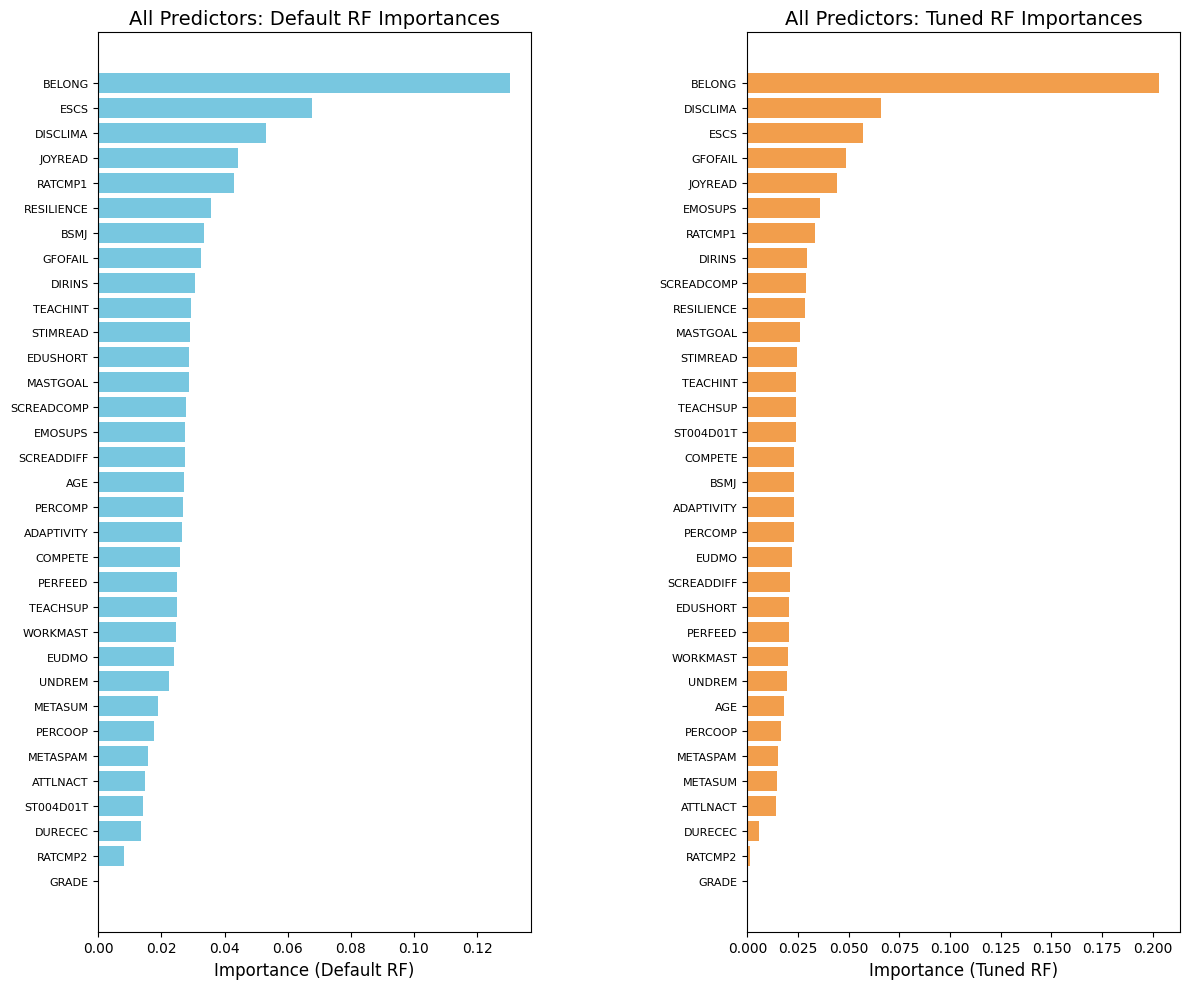

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

df = pd.read_pickle("../data/processed/japan_clean_final.pkl") #loads the final cleaned Japan data
df = df.dropna(subset = ["BEINGBULLIED"]) #drops rows with missing values in the dependent variable

X = df.drop(columns = ["BEINGBULLIED"])
y = df["BEINGBULLIED"]

feature_names = X.columns.tolist() #stores the names of all features

rf_default = RandomForestRegressor(n_estimators = 100, random_state = 42)

tuned_rf = RandomForestRegressor(
    n_estimators = 100,
    max_depth = 20, 
    max_features = 0.5, 
    min_samples_leaf = 10, 
    random_state = 42
)

rf_default.fit(X,y)
tuned_rf.fit(X,y)

imp_default = rf_default.feature_importances_
imp_tuned = tuned_rf.feature_importances_

df_imp_default = (
    pd.DataFrame({"feature": feature_names, "importance": imp_default})
      .sort_values("importance", ascending=True)  
)

df_imp_tuned = (
    pd.DataFrame({"feature": feature_names, "importance": imp_tuned})
      .sort_values("importance", ascending=True)
)

fig, axes = plt.subplots(1, 2, figsize=(12, 10), sharex=False)

axes[0].barh(
    df_imp_default["feature"],
    df_imp_default["importance"],
    color="#78C7E0"
)
axes[0].set_title("All Predictors: Default RF Importances", fontsize=14)
axes[0].set_xlabel("Importance (Default RF)", fontsize=12)
axes[0].tick_params(axis="y", labelsize=8)

#Tuned RF plot
axes[1].barh(
    df_imp_tuned["feature"],
    df_imp_tuned["importance"],
    color="#F29E4C"
)
axes[1].set_title("All Predictors: Tuned RF Importances", fontsize=14)
axes[1].set_xlabel("Importance (Tuned RF)", fontsize=12)
axes[1].tick_params(axis="y", labelsize=8)

# Layout tweaks
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)  # add horizontal space between plots
plt.show()




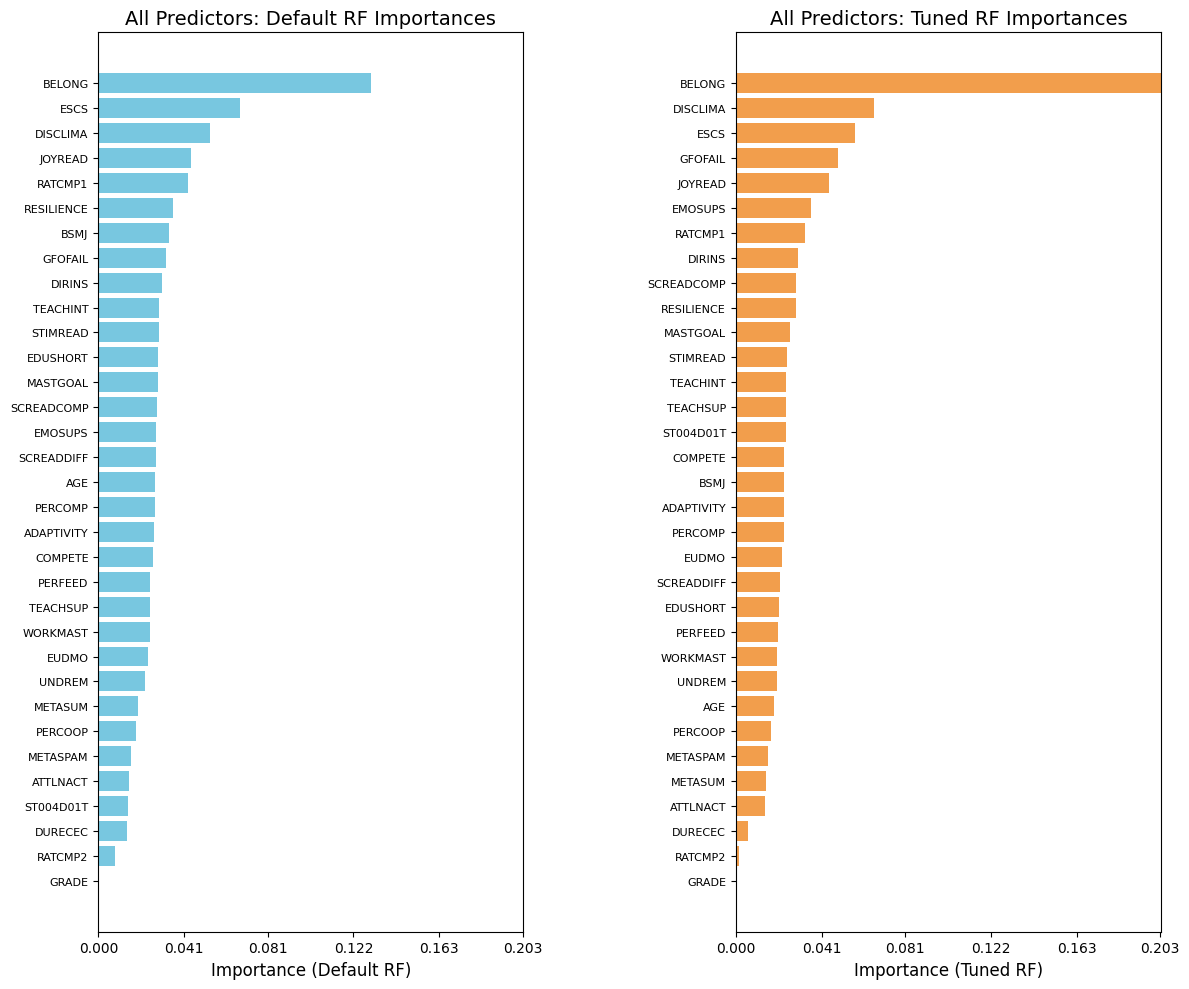

In [10]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

df = pd.read_pickle("../data/processed/japan_clean_final.pkl")  # loads the final cleaned Japan data
df = df.dropna(subset=["BEINGBULLIED"])                        # drops rows with missing values in the dependent variable

X = df.drop(columns=["BEINGBULLIED"])
y = df["BEINGBULLIED"]

feature_names = X.columns.tolist()  # stores the names of all features

rf_default = RandomForestRegressor(n_estimators=100, random_state=42)

tuned_rf = RandomForestRegressor(
    n_estimators = 100,
    max_depth = 20,
    max_features = 0.5,
    min_samples_leaf = 10,
    random_state = 42
)

rf_default.fit(X, y)
tuned_rf.fit(X, y)

imp_default = rf_default.feature_importances_
imp_tuned   = tuned_rf.feature_importances_

df_imp_default = (
    pd.DataFrame({"feature": feature_names, "importance": imp_default})
      .sort_values("importance", ascending=True)
)

df_imp_tuned = (
    pd.DataFrame({"feature": feature_names, "importance": imp_tuned})
      .sort_values("importance", ascending=True)
)

# Compute a common x-axis limit and tick marks
max_imp = max(df_imp_default["importance"].max(), df_imp_tuned["importance"].max())
ticks   = np.linspace(0, max_imp, 6).round(3)  # e.g. 5 intervals

fig, axes = plt.subplots(1, 2, figsize=(12, 10), sharex=True)  # now share x-axis

# Default RF plot
axes[0].barh(
    df_imp_default["feature"],
    df_imp_default["importance"],
    color="#78C7E0"
)
axes[0].set_title("All Predictors: Default RF Importances", fontsize=14)
axes[0].set_xlabel("Importance (Default RF)", fontsize=12)
axes[0].set_xlim(0, max_imp)        # enforce same x-limits
axes[0].set_xticks(ticks)           # enforce same tick marks
axes[0].tick_params(axis="y", labelsize=8)

# Tuned RF plot
axes[1].barh(
    df_imp_tuned["feature"],
    df_imp_tuned["importance"],
    color="#F29E4C"
)
axes[1].set_title("All Predictors: Tuned RF Importances", fontsize=14)
axes[1].set_xlabel("Importance (Tuned RF)", fontsize=12)
axes[1].set_xlim(0, max_imp)        # enforce same x-limits
axes[1].set_xticks(ticks)           # enforce same tick marks
axes[1].tick_params(axis="y", labelsize=8)

plt.tight_layout()
plt.subplots_adjust(wspace=0.5)  # add horizontal space between plots
plt.show()


In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.metrics import make_scorer, mean_absolute_error

df = pd.read_pickle("../data/processed/japan_clean_final.pkl")  # loads the final cleaned Japan data
df = df.dropna(subset=["BEINGBULLIED"])  # drops rows with missing values in the dependent variable

X = df.drop(columns=["BEINGBULLIED"])
y = df["BEINGBULLIED"]

xgb_base = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    verbosity=0
)

rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

neg_mae = cross_val_score(
    xgb_base, X, y,
    cv=rkf,
    scoring=mae_scorer,
    n_jobs=-1
)
mae_scores = -neg_mae
print("Baseline XGB MAE:", np.round(mae_scores.mean(), 3),
      "±", np.round(mae_scores.std(), 3))


Baseline XGB MAE: 0.615 ± 0.016


In [2]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.metrics import make_scorer, mean_absolute_error
import numpy as np
import pandas as pd 

xgb = XGBRegressor(random_state = 42, verbosity = 0) #defines base XGBoost model 

param_grid = {
    "n_estimators": [100, 300, 500], # number of trees in the ensemble
    "max_depth": [4, 6, 8, 10], # maximum depth of each tree
    "learning_rate": [0.01, 0.05, 0.1, 0.2], # step size shrinkage to prevent overfitting
    "subsample": [0.6, 0.8, 1.0], # fraction of samples to use for fitting each tree
    "colsample_bytree": [0.6, 0.8, 1.0] # fraction of features to use for fitting each tree
}

rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42) #defines repeated k-fold cross-validation

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False) #defines mean absolute error scorer

grid_search = GridSearchCV(
    estimator = xgb, 
    param_grid = param_grid, 
    cv = rkf, 
    scoring = "neg_mean_absolute_error", 
    n_jobs = -1, 
    verbose = 2
)

df = pd.read_pickle("../data/processed/japan_clean_final.pkl")  # loads the final cleaned Japan data
df = df.dropna(subset=["BEINGBULLIED"])  # drops rows with missing values in the dependent variable

X = df.drop(columns=["BEINGBULLIED"])
y = df["BEINGBULLIED"]

grid_search.fit(X, y) 

best_params = grid_search.best_params_
best_mae = -grid_search.best_score_

print("Best XGB params (MAE): ", best_params)
print("Best CV MAE: ", np.round(best_mae, 3))



Fitting 10 folds for each of 432 candidates, totalling 4320 fits
Best XGB params (MAE):  {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.8}
Best CV MAE:  0.604


In [2]:
from xgboost import XGBRegressor
import pandas as pd

df = pd.read_pickle("../data/processed/japan_clean_final.pkl")  # loads the final cleaned Japan data
df = df.dropna(subset=["BEINGBULLIED"])  # drops rows with missing values in the dependent variable

X = df.drop(columns=["BEINGBULLIED"])
y = df["BEINGBULLIED"]

best_xgb = XGBRegressor(
    n_estimators = 300,
    max_depth = 4,
    learning_rate = 0.05,
    subsample = 0.8,
    colsample_bytree = 0.8,
    random_state = 42,
    verbosity = 0
)

best_xgb.fit(X, y)

importances = best_xgb.feature_importances_  # get feature importances
feat_imp = sorted(zip(X.columns, importances), key=lambda pair: pair[1], reverse=True)

print("Top 10 XGB predictors of BEINGBULLIED (Japan):")
for feat, imp in feat_imp[:10]:
    print(f"  {feat:<12s}: {imp:.4f}")


Top 10 XGB predictors of BEINGBULLIED (Japan):
  BELONG      : 0.0805
  ST004D01T   : 0.0531
  GFOFAIL     : 0.0463
  DISCLIMA    : 0.0416
  EMOSUPS     : 0.0380
  SCREADCOMP  : 0.0359
  ESCS        : 0.0358
  PERCOOP     : 0.0323
  EDUSHORT    : 0.0320
  DIRINS      : 0.0315


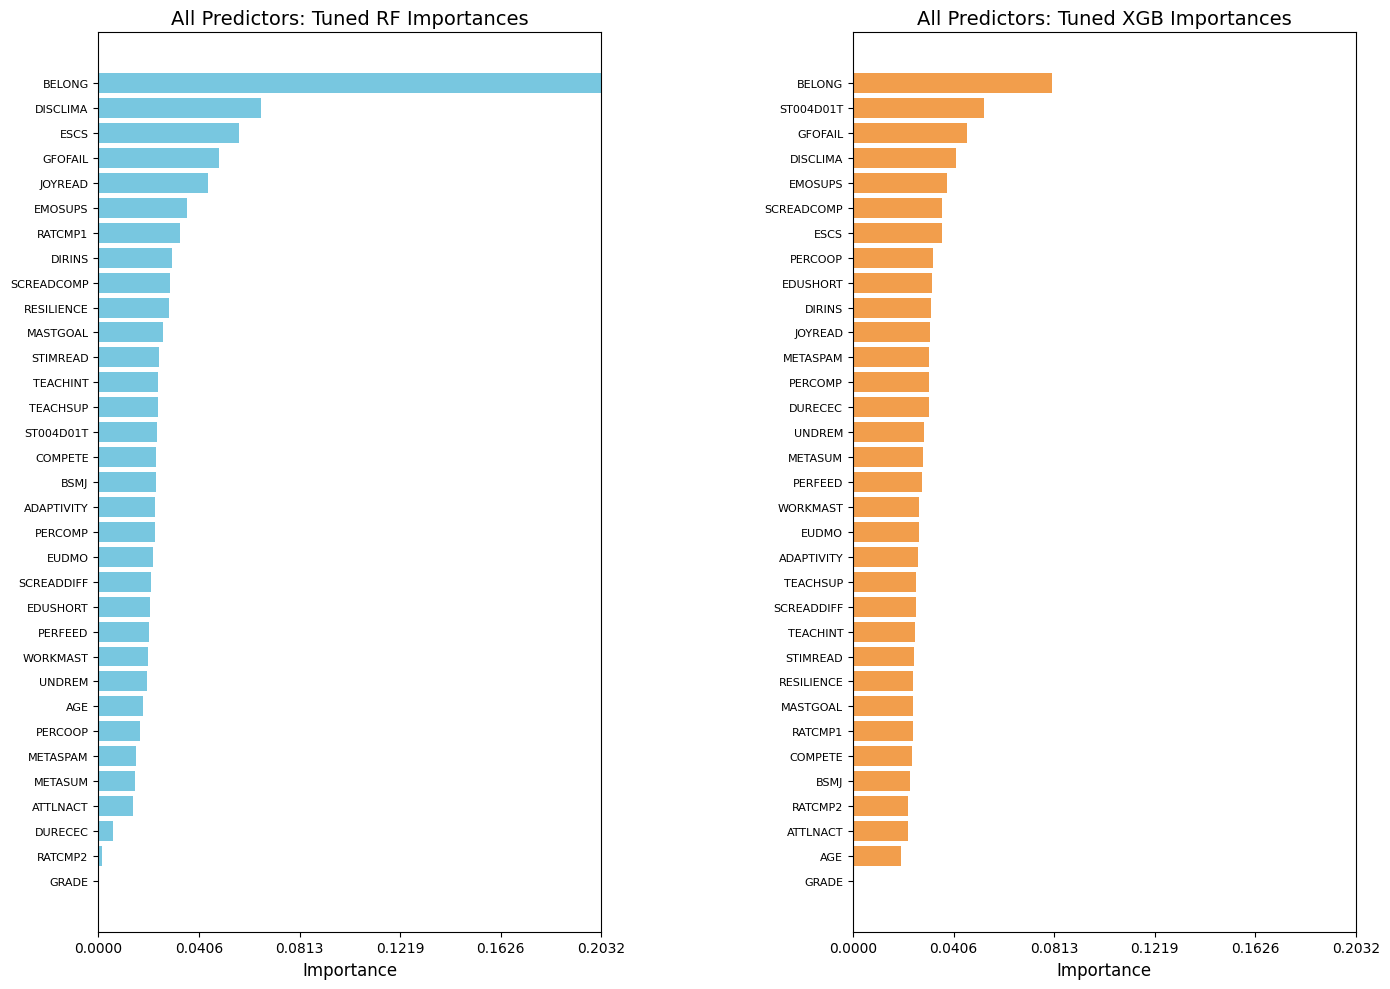

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

df = pd.read_pickle("../data/processed/japan_clean_final.pkl")  # loads the final cleaned Japan data
df = df.dropna(subset=["BEINGBULLIED"])  # drops rows with missing values in the dependent variable

X = df.drop(columns=["BEINGBULLIED"])
y = df["BEINGBULLIED"]

tuned_rf = RandomForestRegressor(
    n_estimators = 100,
    max_depth = 20,
    max_features = 0.5,
    min_samples_leaf = 10,
    random_state = 42
)

tuned_rf.fit(X, y)
imp_rf = tuned_rf.feature_importances_

tuned_xgb = XGBRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=0
)

tuned_xgb.fit(X, y)
imp_xgb = tuned_xgb.feature_importances_

feature_names = X.columns.tolist()
df_imp_rf = pd.DataFrame({"feature": feature_names, "importance": imp_rf}) \
    .sort_values("importance", ascending=True)
df_imp_xgb = pd.DataFrame({"feature": feature_names, "importance": imp_xgb}) \
    .sort_values("importance", ascending=True)

max_imp = max(df_imp_rf["importance"].max(), df_imp_xgb["importance"].max())

xticks = np.linspace(0, max_imp, 6)

fig, axes = plt.subplots(1, 2, figsize=(14, 10), sharex=True)

axes[0].barh(df_imp_rf["feature"], df_imp_rf["importance"], color="#78C7E0")
axes[0].set_title("All Predictors: Tuned RF Importances", fontsize=14)
axes[0].set_xlabel("Importance", fontsize=12)
axes[0].set_xlim(0, max_imp)
axes[0].set_xticks(xticks)
axes[0].tick_params(axis="y", labelsize=8)

axes[1].barh(df_imp_xgb["feature"], df_imp_xgb["importance"], color="#F29E4C")
axes[1].set_title("All Predictors: Tuned XGB Importances", fontsize=14)
axes[1].set_xlabel("Importance", fontsize=12)
axes[1].set_xlim(0, max_imp)
axes[1].set_xticks(xticks)
axes[1].tick_params(axis="y", labelsize=8)

plt.tight_layout()
plt.subplots_adjust(wspace=0.5)
plt.show()


In [1]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.metrics import make_scorer, mean_absolute_error
import numpy as np
import pandas as pd

df = pd.read_pickle("../data/processed/japan_clean_final.pkl")  # loads the final cleaned Japan data
df = df.dropna(subset=["BEINGBULLIED"])  # drops rows with missing values in the dependent variable

X = df.drop(columns=["BEINGBULLIED"])
y = df["BEINGBULLIED"]

lgb_base = LGBMRegressor(
    n_estimators = 300,
    learning_rate = 0.05,
    random_state = 42,
    silent = True
)

rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

neg_mae = cross_val_score(lgb_base, X, y, cv=rkf, scoring=mae_scorer, n_jobs=-1)

mae = -neg_mae  # convert negative MAE to positive

print("Baseline LGBM MAE:", np.round(mae.mean(),3),"±", np.round(mae.std(),3))

Baseline LGBM MAE: 0.61 ± 0.014


In [3]:
from lightgbm import LGBMRegressor
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingRandomSearchCV, RepeatedKFold
from sklearn.metrics import make_scorer, mean_absolute_error
import pandas as pd
import numpy as np

df = pd.read_pickle("../data/processed/japan_clean_final.pkl")
df = df.dropna(subset=["BEINGBULLIED"])
X = df.drop(columns=["BEINGBULLIED"])
y = df["BEINGBULLIED"]

lgb = LGBMRegressor(random_state=42, verbosity=0)

param_grid = {
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "max_depth": [3, 5, 7, 9],
    "num_leaves": [31, 50, 80, 120],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}

rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

halving = HalvingRandomSearchCV(
    estimator = lgb,
    param_distributions = param_grid,
    resource = "n_estimators",  # use n_estimators as the resource to halve
    factor = 3,               # how aggressively to cut candidates each round
    min_resources = 100,       # start by fitting 100 trees per candidate
    max_resources = 800,      # finish by fitting up to 800 trees
    cv = rkf,
    scoring = "neg_mean_absolute_error",
    n_jobs = -1,
    random_state = 42,
    verbose = 2
)

halving.fit(X, y)

print("▶︎ Halving Random Search best params:", halving.best_params_)
print("▶︎ Halving CV MAE:", -halving.best_score_)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 100
max_resources_: 800
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 8
n_resources: 100
Fitting 10 folds for each of 8 candidates, totalling 80 fits
----------
iter: 1
n_candidates: 3
n_resources: 300
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.metrics import make_scorer, mean_absolute_error
import pandas as pd
import numpy as np


df = pd.read_pickle("../data/processed/japan_clean_final.pkl")
df = df.dropna(subset=["BEINGBULLIED"])
X = df.drop(columns=["BEINGBULLIED"])
y = df["BEINGBULLIED"]

lgb = LGBMRegressor(random_state=42, verbosity=0)

param_grid = {
    "n_estimators": [300, 500, 800, 1000],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "max_depth": [3, 5, 7, 9],
    "num_leaves": [31, 50, 80, 120],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}

rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

grid = GridSearchCV(
    estimator = LGBMRegressor(random_state=42, verbosity=0),
    param_grid = param_grid,
    cv = rkf,
    scoring = "neg_mean_absolute_error",
    n_jobs = -1,
    verbose = 2
)

grid.fit(X, y)

best_lgb = grid.best_estimator_
best_mae = -grid.best_score_

print(" Best LGBM params:", grid.best_params_)
print(" Best CV MAE:", np.round(best_mae, 3))







Fitting 10 folds for each of 2304 candidates, totalling 23040 fits


In [ ]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.metrics import make_scorer, mean_absolute_error

df = pd.read_pickle("../data/processed/japan_clean_final.pkl")
df = df.dropna(subset=["BEINGBULLIED"])
X = df.drop(columns=["BEINGBULLIED"])
y = df["BEINGBULLIED"]

rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

param_grid_1 = {
    "n_estimators": [100, 300, 500, 800, 1000],
    "learning_rate": [0.01, 0.03, 0.05, 0.1, 0.15, 0.2],
}

grid = GridSearchCV(
    estimator=LGBMRegressor(random_state=42, verbosity=0),
    param_grid=param_grid_1,
    cv=rkf,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=2
)
grid.fit(X, y)

best_params = grid.best_params_
print("Stage 1 best params:", best_params)
print("Stage 1 best MAE:", -grid.best_score_)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
Stage 1 best params: {'learning_rate': 0.01, 'n_estimators': 800}
Stage 1 best MAE: 0.6087047855559051


In [ ]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.metrics import make_scorer, mean_absolute_error

df = pd.read_pickle("../data/processed/japan_clean_final.pkl")
df = df.dropna(subset=["BEINGBULLIED"])
X = df.drop(columns=["BEINGBULLIED"])
y = df["BEINGBULLIED"]

lgb_test = LGBMRegressor(
    random_state = 42,
    verbosity = 0, 
    n_estimators = 800, 
    learning_rate = 0.01
)

param_grid= {
    "max_depth": [3, 5, 7, 9, 11],
    "num_leaves": [31, 50, 80, 120, 150, 200]
}

rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

grid = GridSearchCV(
    estimator = lgb_test,
    param_grid = param_grid,
    cv = rkf,
    scoring = "neg_mean_absolute_error",
    n_jobs = -1,
    verbose = 2 
)

grid.fit(X, y)

best_params= grid.best_params_
print("Stage 2 best params:", best_params)
print("Stage 2 best MAE:", -grid.best_score_)



Fitting 10 folds for each of 30 candidates, totalling 300 fits
Stage 2 best params: {'max_depth': 11, 'num_leaves': 31}
Stage 2 best MAE: 0.6082810084621117


In [7]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.metrics import make_scorer, mean_absolute_error

df = pd.read_pickle("../data/processed/japan_clean_final.pkl")
df = df.dropna(subset=["BEINGBULLIED"])
X = df.drop(columns=["BEINGBULLIED"])
y = df["BEINGBULLIED"]

lgb_test = LGBMRegressor(
    random_state = 42,
    verbosity = 0, 
    n_estimators = 800, 
    learning_rate = 0.01,
    max_depth = 11,
    num_leaves = 31
)

param_grid= {
    "subsample": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

grid = GridSearchCV(
    estimator = lgb_test,
    param_grid = param_grid,
    cv = rkf,
    scoring = "neg_mean_absolute_error",
    n_jobs = -1,
    verbose = 2 
)

grid.fit(X, y)

best = grid.best_params_
print("Stage 3 best params:", best)
print("Stage 3 best MAE:", -grid.best_score_)



Fitting 10 folds for each of 36 candidates, totalling 360 fits
Stage 3 best params: {'colsample_bytree': 0.7, 'subsample': 0.5}
Stage 3 best MAE: 0.6063170933995721


In [ ]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.metrics import make_scorer, mean_absolute_error

df = pd.read_pickle("../data/processed/japan_clean_final.pkl")
df = df.dropna(subset=["BEINGBULLIED"])
X = df.drop(columns=["BEINGBULLIED"])
y = df["BEINGBULLIED"]


lgb_base = LGBMRegressor(
    n_estimators = 800,
    learning_rate = 0.01,
    max_depth = 11,
    num_leaves = 31,
    subsample = 0.5,
    colsample_bytree = 0.7,
    random_state = 42,
    verbosity = 0
)

param_grid = {
    "n_estimators": [700, 800, 900],
    "learning_rate": [0.005, 0.01, 0.02],
    "max_depth": [10, 11, 13],
    "num_leaves": [20, 31, 40],
    "subsample": [0.4, 0.5, 0.6],
    "colsample_bytree": [0.6, 0.7, 0.8],
}

rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

gs = GridSearchCV(
    estimator=lgb_base,
    param_grid=param_grid,
    cv=rkf,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1
)

gs.fit(X, y)

best_params = gs.best_params_
best_mae = -gs.best_score_
print("Final tight‐grid LGBM params:", best_params)
print("Final tight‐grid CV MAE:", best_mae.round(3))





Fitting 10 folds for each of 729 candidates, totalling 7290 fits
▶︎ Final tight‐grid LGBM params: {'colsample_bytree': 0.6, 'learning_rate': 0.02, 'max_depth': 13, 'n_estimators': 700, 'num_leaves': 40, 'subsample': 0.4}
▶︎ Final tight‐grid CV MAE: 0.605


In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from sklearn.metrics import make_scorer, mean_absolute_error

df = pd.read_pickle("../data/processed/japan_clean_final.pkl")
df = df.dropna(subset=["BEINGBULLIED"])

X = df.drop(columns=["BEINGBULLIED"])
y = df["BEINGBULLIED"]

base_params = dict(
    n_estimators = 300,
    max_depth = 4,
    learning_rate = 0.05,
    subsample = 0.8,
    colsample_bytree = 0.8,
    objective = "reg:squarederror",
)

reg_parameters = {
    "gamma": [0, 0.1, 0.25, 0.5, 1.0],
    "min_child_weight": [1, 3, 5, 7],
    "reg_alpha": [0, 0.05, 0.15, 0.3, 0.6],   
    "reg_lambda": [0.5, 1, 2, 4, 6]         
}

rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

grid = RandomizedSearchCV(
    estimator= XGBRegressor(**base_params, random_state=42, verbosity=0),
    param_distributions = reg_parameters,
    n_iter = 64,
    cv = rkf,
    scoring = "neg_mean_absolute_error",
    n_jobs = -1,
    random_state = 42,
    verbose = 2
)

grid.fit(X, y)

best_mae   = -grid.best_score_
print("\nRegularisation-only best MAE:", round(best_mae, 3))
print("With regularisation params:")
for k, v in grid.best_params_.items():
    print(f"   {k:<16s}: {v}")


Fitting 10 folds for each of 64 candidates, totalling 640 fits

 Regularisation-only best MAE: 0.603
With regularisation params:
   reg_lambda      : 4
   reg_alpha       : 0.6
   min_child_weight: 5
   gamma           : 0
CPU times: total: 8.19 s
Wall time: 1min 50s
